In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv('../house_prices.csv')
print(df.columns)
print(df.columns.size)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"Coloane categorice ({len(categorical_features)}): {categorical_features}")


Coloane numerice (37): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Coloane categorice (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X = df.drop('SalePrice', axis=1) if 'SalePrice' in df.columns else df
Y = df['SalePrice'] if 'SalePrice' in df.columns else None

X_encoded = preprocessor.fit_transform(X)
print(f"Dimensiunea setului de date după codificare: {X_encoded.shape}")

Dimensiunea setului de date după codificare: (1460, 304)


In [6]:
if hasattr(X_encoded, 'toarray'):
    print("Converting sparse matrix to dense array...")
    X_encoded = X_encoded.toarray()
    print(f"After conversion: {X_encoded.shape}")


Converting sparse matrix to dense array...
After conversion: (1460, 304)


In [7]:
cat_encoder = preprocessor.named_transformers_['cat']
categorical_encoded_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_encoded_names)


In [8]:
print(f"\nTotal feature names: {len(all_feature_names)}")
print(f"X_encoded columns: {X_encoded.shape[1]}")
print(f"Match: {len(all_feature_names) == X_encoded.shape[1]}")


Total feature names: 304
X_encoded columns: 304
Match: True


In [9]:
df_encoded = pd.DataFrame(X_encoded, columns=all_feature_names)
df_encoded['SalePrice'] = Y.values

In [10]:
print(f"\ndf_encoded shape: {df_encoded.shape}")
print(f"\nFirst few columns: {df_encoded.columns[:10].tolist()}")


df_encoded shape: (1460, 305)

First few columns: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']


In [11]:
correlation_matrix = df_encoded.corr()
target_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

In [12]:
print("\n" + "="*80)
print("Corelația caracteristicilor cu SalePrice")
print("="*80)
print(target_correlation.head(90).to_string())


Corelația caracteristicilor cu SalePrice
SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
BsmtQual_Ex              0.553105
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
KitchenQual_Ex           0.504094
Foundation_PConc         0.497734
GarageYrBlt              0.486362
MasVnrArea               0.477493
Fireplaces               0.466929
ExterQual_Gd             0.452466
ExterQual_Ex             0.451164
BsmtFinType1_GLQ         0.434597
HeatingQC_Ex             0.434543
GarageFinish_Fin         0.419678
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
SaleType_New             0.357509
SaleCondition_Partial    0.352060
LotFrontage              0.351799
FireplaceQu_Gd           0.339329
Garage

#  Feature Correlation Analysis with SalePrice

| Rank | Feature | Correlation | Category |
|:----:|:--------|:-----------:|:--------:|
| 1 | **SalePrice** | 1.000000 | 🎯 Target |
| 2 | **OverallQual** | 0.790982 | de luat in calcul |
| 3 | **GrLivArea** | 0.708624 | de luat in calcul |
| 4 | **GarageCars** | 0.640409 | de luat in calcul |
| 5 | **GarageArea** | 0.623431 | de luat in calcul |
| 6 | **TotalBsmtSF** | 0.613581 |  poate  |
| 7 | **1stFlrSF** | 0.605852 | de luat in calcul |
| 8 | **FullBath** | 0.560664 | poate/ de luat in calcul |
| 10 | **TotRmsAbvGrd** | 0.533723 | de luat in calcul |
| 11 | **YearBuilt** | 0.522897 | poate/de luat in calcul |
| 12 | **YearRemodAdd** | 0.507101 | poate/ nu cred |
| 13 | **KitchenQual_Ex** | 0.504094 | poate/ nu cred |
| 14 | **Foundation_PConc** | 0.497734 | poate / nu cred |
| 15 | **GarageYrBlt** | 0.486362 | irelevant dpmdv |
| 16 | **MasVnrArea** | 0.477493 | poate - depinde de user |
| 17 | **Fireplaces** | 0.466929 | poate/nu cred |
| 18 | **ExterQual_Gd** | 0.452466 | Da, merge |
| 21 | **HeatingQC_Ex** | 0.434543 | poate |
| 23 | **Neighborhood_NridgHt** | 0.402149 | maybe |
| 27 | **LotFrontage** | 0.351799 | poate |
| 34 | 2ndFlrSF | 0.319334 | daca are da ;) |
| 39 | HalfBath | 0.284108 | poate |
| 41 | LotArea | 0.263843 | poate/ de luat in calcul |
| 47 | Electrical_SBrkr | 0.241896 | poate |

In [13]:
selected_numerical_features = [
    'OverallQual',  # 
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'FullBath',
    'TotRmsAbvGrd',
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt',
    'MasVnrArea',
    'Fireplaces',
    'LotFrontage',
    '2ndFlrSF',
    'HalfBath',
    'LotArea'
]

selected_categorical_base = [
    'KitchenQual',      # KitchenQual_Ex în tabel
    'Foundation',       # Foundation_PConc în tabel
    'ExterQual',        # ExterQual_Gd în tabel
    'HeatingQC',        # HeatingQC_Ex în tabel
    'Neighborhood',     # Neighborhood_NridgHt în tabel
    'Electrical'        # Electrical_SBrkr în tabel
]

## Numerical Features

| Feature | Description | Details |
|---------|-------------|---------|
| **OverallQual** | Overall material and finish quality | Scale 1-10 (1=Very Poor, 10=Very Excellent) |
| **GrLivArea** | Above grade living area | Square feet of living space (excluding basement) |
| **GarageCars** | Garage capacity | Number of cars that can fit |
| **GarageArea** | Garage size | Square feet |
| **TotalBsmtSF** | Total basement area | Square feet |
| **1stFlrSF** | First floor area | Square feet |
| **FullBath** | Full bathrooms | Count above grade (not basement) |
| **TotRmsAbvGrd** | Total rooms above grade | Count (excludes bathrooms) |
| **YearBuilt** | Construction year | Original construction date |
| **YearRemodAdd** | Remodel year | Same as construction if no remodeling |
| **GarageYrBlt** | Garage construction year | Year garage was built |
| **MasVnrArea** | Masonry veneer area | Square feet of stone/brick facing |
| **Fireplaces** | Number of fireplaces | Count |
| **LotFrontage** | Street frontage | Linear feet connected to street |
| **2ndFlrSF** | Second floor area | Square feet (0 if single-story) |
| **HalfBath** | Half bathrooms | Count above grade |
| **LotArea** | Lot size | Total square feet of property |

## Selected Categorical Features

| Feature | Description | Possible Values |
|---------|-------------|-----------------|
| **KitchenQual** | Kitchen quality | Ex (Excellent), Gd (Good), TA (Average), Fa (Fair), Po (Poor) |
| **Foundation** | Foundation type | PConc (Poured Concrete), CBlock (Cinder Block), BrkTil (Brick & Tile), Slab, Stone, Wood |
| **ExterQual** | Exterior material quality | Ex (Excellent), Gd (Good), TA (Average), Fa (Fair), Po (Poor) |
| **HeatingQC** | Heating quality & condition | Ex (Excellent), Gd (Good), TA (Average), Fa (Fair), Po (Poor) |
| **Neighborhood** | Location within Ames | 25 neighborhoods (e.g., NridgHt, CollgCr, OldTown, Edwards, etc.) |
| **Electrical** | Electrical system type | SBrkr (Standard Breakers), FuseA (Fuse >60A), FuseF (60A Fair), FuseP (60A Poor), Mix |

In [14]:
available_numerical = [f for f in selected_numerical_features if f in df.columns]
available_categorical = [f for f in selected_categorical_base if f in df.columns]

print("="*80)
print("SELECTED FEATURES")
print("="*80)
print(f"\nNumerical features ({len(available_numerical)}):")
for i, feat in enumerate(available_numerical, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nCategorical features ({len(available_categorical)}) - TOATE valorile:")
for i, feat in enumerate(available_categorical, 1):
    unique_vals = df[feat].nunique()
    print(f"  {i:2d}. {feat} ({unique_vals} unique values)")

X = df[available_numerical + available_categorical].copy()
Y = df['SalePrice']

X[available_numerical] = X[available_numerical].fillna(0)
X_encoded = pd.get_dummies(X, columns=available_categorical, drop_first=False)

print(f"\nShape înainte de encoding: {X.shape}")
print(f"Shape după encoding: {X_encoded.shape}")
print(f"\nPrimele coloane după encoding:")
print(X_encoded.columns.tolist()[:30])

SELECTED FEATURES

Numerical features (17):
   1. OverallQual
   2. GrLivArea
   3. GarageCars
   4. GarageArea
   5. TotalBsmtSF
   6. 1stFlrSF
   7. FullBath
   8. TotRmsAbvGrd
   9. YearBuilt
  10. YearRemodAdd
  11. GarageYrBlt
  12. MasVnrArea
  13. Fireplaces
  14. LotFrontage
  15. 2ndFlrSF
  16. HalfBath
  17. LotArea

Categorical features (6) - TOATE valorile:
   1. KitchenQual (4 unique values)
   2. Foundation (6 unique values)
   3. ExterQual (4 unique values)
   4. HeatingQC (5 unique values)
   5. Neighborhood (25 unique values)
   6. Electrical (5 unique values)

Shape înainte de encoding: (1460, 23)
Shape după encoding: (1460, 66)

Primele coloane după encoding:
['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'LotFrontage', '2ndFlrSF', 'HalfBath', 'LotArea', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Founda

In [15]:
from sklearn.metrics import mean_squared_error


X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor(random_state=42)
model.fit(X_train_scaled, Y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²: {r2:.4f}")

MAE: $18,742
RMSE: $30,079
R²: 0.8820


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, Y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"\nBest params: {grid_search.best_params_}")
print(f"\nMAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²: {r2:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}

MAE: $16,924
RMSE: $27,182
R²: 0.9037


In [17]:
import joblib
joblib.dump(best_model, 'xgb_model.joblib')


['xgb_model.joblib']

# Clasification


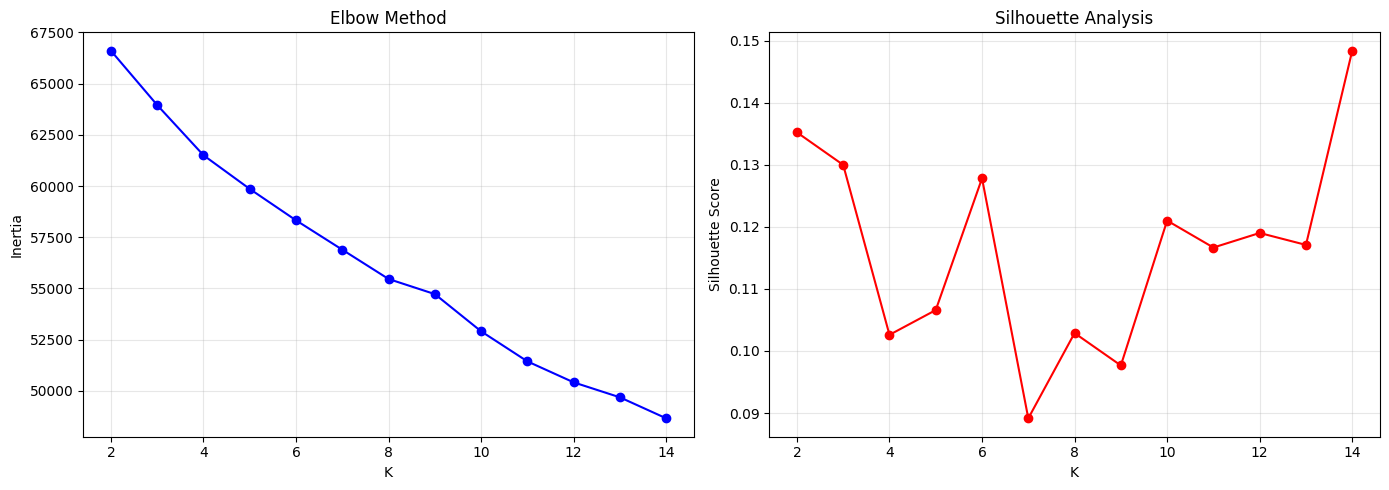

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_values = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertia_values, 'bo-')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
scaler_cluster = StandardScaler()
X_scaled_cluster = scaler_cluster.fit_transform(X_encoded)
cluster_labels = kmeans.fit_predict(X_scaled_cluster)

X_with_clusters = X_encoded.copy()
X_with_clusters['ClusterLabel'] = cluster_labels

print(f"\nDistribuția clusterelor:")
print(pd.Series(cluster_labels).value_counts().sort_index())
print(f"\nStatistici SalePrice pe clustere:")
cluster_stats = df.loc[X_with_clusters.index].groupby(cluster_labels)['SalePrice'].describe()
print(cluster_stats)


Distribuția clusterelor:
0    420
1    247
2    458
3     41
4    199
5     95
Name: count, dtype: int64

Statistici SalePrice pe clustere:
   count           mean            std       min       25%       50%  \
0  420.0  209373.359524   44655.082100  130000.0  178555.0  201000.0   
1  247.0  117958.627530   34328.049084   34900.0   94125.0  117000.0   
2  458.0  132551.569869   23685.711182   60000.0  118884.5  134000.0   
3   41.0  335295.317073  121412.658640  190000.0  265000.0  301500.0   
4  199.0  198472.175879   49805.173229   82500.0  165000.0  187500.0   
5   95.0  348638.568421   82768.069759  160000.0  286545.0  325624.0   

        75%       max  
0  232700.0  424870.0  
1  137500.0  214500.0  
2  148000.0  207500.0  
3  341000.0  755000.0  
4  225500.0  385000.0  
5  389375.0  611657.0  


In [20]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

X_clf = X_with_clusters.drop('ClusterLabel', axis=1)
Y_clusters = X_with_clusters['ClusterLabel']

X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split( X_clf, Y_clusters, test_size=0.2, random_state=42, stratify=Y_clusters )
scaler_clf = StandardScaler()

X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

clf_model = XGBClassifier(
    objective='multi:softmax',
    num_class=optimal_k,
    random_state=42
)

clf_model.fit(X_train_clf_scaled, Y_train_clf)
y_pred_clf = clf_model.predict(X_test_clf_scaled)

print(f"Accuracy: {accuracy_score(Y_test_clf, y_pred_clf):.4f}")
print(f"\nClassification Report:")
print(classification_report(Y_test_clf, y_pred_clf))

Accuracy: 0.9418

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98        84
           1       0.88      1.00      0.93        49
           2       0.99      0.91      0.95        92
           3       1.00      1.00      1.00         8
           4       0.83      0.85      0.84        40
           5       0.95      1.00      0.97        19

    accuracy                           0.94       292
   macro avg       0.94      0.95      0.95       292
weighted avg       0.95      0.94      0.94       292



In [21]:
X_reg = X_with_clusters.drop('ClusterLabel', axis=1)
Y_reg = Y

X_train_reg, X_temp_reg, Y_train_reg, Y_temp_reg = train_test_split(X_reg, Y_reg, test_size=0.4, random_state=42 )
X_val_reg, X_test_reg, Y_val_reg, Y_test_reg = train_test_split( X_temp_reg, Y_temp_reg, test_size=0.5, random_state=42 )

print(f"\nTrain: {X_train_reg.shape[0]} samples ({X_train_reg.shape[0]/len(X_reg)*100:.0f}%)")
print(f"Val:   {X_val_reg.shape[0]} samples ({X_val_reg.shape[0]/len(X_reg)*100:.0f}%)")
print(f"Test:  {X_test_reg.shape[0]} samples ({X_test_reg.shape[0]/len(X_reg)*100:.0f}%)")



Train: 876 samples (60%)
Val:   292 samples (20%)
Test:  292 samples (20%)


In [22]:
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_val_reg_scaled = scaler_reg.transform(X_val_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_reg_scaled, Y_train_reg)

y_val_pred = model.predict(X_val_reg_scaled)
val_mae = mean_absolute_error(Y_val_reg, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(Y_val_reg, y_val_pred))
val_r2 = r2_score(Y_val_reg, y_val_pred)

y_test_pred = model.predict(X_test_reg_scaled)
test_mae = mean_absolute_error(Y_test_reg, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test_reg, y_test_pred))
test_r2 = r2_score(Y_test_reg, y_test_pred)

print("\nValidation Set Performance:")
print(f"   MAE:  ${val_mae:,.0f}")
print(f"   RMSE: ${val_rmse:,.0f}")
print(f"   R²:   {val_r2:.4f}")

print("\nTest Set Performance:")
print(f"   MAE:  ${test_mae:,.0f}")
print(f"   RMSE: ${test_rmse:,.0f}")
print(f"   R²:   {test_r2:.4f}")

print("\nComparison (Val vs Test):")
print(f"   MAE difference:  ${abs(val_mae - test_mae):,.0f}")
print(f"   RMSE difference: ${abs(val_rmse - test_rmse):,.0f}")
print(f"   R² difference:   {abs(val_r2 - test_r2):.4f}")


Validation Set Performance:
   MAE:  $20,275
   RMSE: $41,068
   R²:   0.8209

Test Set Performance:
   MAE:  $17,077
   RMSE: $24,682
   R²:   0.8754

Comparison (Val vs Test):
   MAE difference:  $3,198
   RMSE difference: $16,386
   R² difference:   0.0545


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [24]:
X_clf = X_with_clusters.drop('ClusterLabel', axis=1)
Y_clusters = X_with_clusters['ClusterLabel']

X_train_clf, X_temp_clf, Y_train_clf, Y_temp_clf = train_test_split( X_clf, Y_clusters, test_size=0.4, random_state=42, stratify=Y_clusters )
X_val_clf, X_test_clf, Y_val_clf, Y_test_clf = train_test_split( X_temp_clf, Y_temp_clf, test_size=0.5, random_state=42, stratify=Y_temp_clf)

print(f"Train: {X_train_clf.shape[0]} samples ({X_train_clf.shape[0]/len(X_clf)*100:.0f}%)")
print(f"Val:   {X_val_clf.shape[0]} samples ({X_val_clf.shape[0]/len(X_clf)*100:.0f}%)")
print(f"Test:  {X_test_clf.shape[0]} samples ({X_test_clf.shape[0]/len(X_clf)*100:.0f}%)")

Train: 876 samples (60%)
Val:   292 samples (20%)
Test:  292 samples (20%)


In [25]:
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_val_clf_scaled = scaler_clf.transform(X_val_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

clf_model = XGBClassifier(objective='multi:softmax', num_class=optimal_k, n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42 )
clf_model.fit(X_train_clf_scaled, Y_train_clf)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
y_val_clf_pred = clf_model.predict(X_val_clf_scaled)
val_accuracy = accuracy_score(Y_val_clf, y_val_clf_pred)
y_test_clf_pred = clf_model.predict(X_test_clf_scaled)
test_accuracy = accuracy_score(Y_test_clf, y_test_clf_pred)

print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
print("="*80)
print(f"Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(Y_val_clf, y_val_clf_pred))

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)
print(f"Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test_clf, y_test_clf_pred))

print("\n" + "="*80)
print("COMPARISON (Val vs Test)")
print("="*80)
print(f"Accuracy difference: {abs(val_accuracy - test_accuracy):.4f}")


VALIDATION SET PERFORMANCE
Accuracy: 0.9349

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.89      0.98      0.93        49
           2       0.96      0.95      0.95        92
           3       1.00      1.00      1.00         8
           4       0.89      0.85      0.87        40
           5       1.00      0.89      0.94        19

    accuracy                           0.93       292
   macro avg       0.95      0.94      0.94       292
weighted avg       0.94      0.93      0.93       292


TEST SET PERFORMANCE
Accuracy: 0.9486

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        84
           1       0.91      0.98      0.94        50
           2       0.98      0.97      0.97        91
           3       1.00      1.00      1.00         8
           4       0.87      0.85      0.86        40


# Gestionarea Feature-urilor Lipsa in modele de predictie


In [27]:
mandatory_numerical_features = {
    'OverallQual',
    'GrLivArea',
    '1stFlrSF',
    'FullBath',
    'TotRmsAbvGrd',
    'YearBuilt',
    'LotArea'
}

optional_numerical_features = {
    'YearRemodAdd',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    'MasVnrArea',
    'Fireplaces',
    'LotFrontage',
    '2ndFlrSF',
    'HalfBath'
}

mandatory_categorical_features = [
    'KitchenQual',      
    'Foundation',       
    'ExterQual',        
    'Neighborhood'      
]

optional_categorical_features = [
    'HeatingQC',        
    'Electrical'        
]

all_mandatory_features = list(mandatory_numerical_features) + mandatory_categorical_features
all_optional_features = list(optional_numerical_features) + optional_categorical_features
selected_features = all_mandatory_features + all_optional_features

In [28]:
from sklearn.impute import SimpleImputer


mandatory_numerical = list(mandatory_numerical_features)
optional_numerical = list(optional_numerical_features)
mandatory_categorical = mandatory_categorical_features
optional_categorical = optional_categorical_features


preprocessor = ColumnTransformer(
    transformers=[
        ('mandatory_num', SimpleImputer(strategy='median'), mandatory_numerical),
        
        ('optional_num', SimpleImputer(strategy='median', add_indicator=True), optional_numerical),
        
        ('mandatory_cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), mandatory_categorical),
        
        ('optional_cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), optional_categorical)
    ]
)


complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42))
])  

In [29]:
all_required_features = mandatory_numerical + optional_numerical + mandatory_categorical + optional_categorical
X_pipeline = df[all_required_features].copy()
Y_pipeline = df['SalePrice']

X_train_pipe, X_temp_pipe, Y_train_pipe, Y_temp_pipe = train_test_split( X_pipeline, Y_pipeline, test_size=0.4, random_state=42 )
X_val_pipe, X_test_pipe, Y_val_pipe, Y_test_pipe = train_test_split( X_temp_pipe, Y_temp_pipe, test_size=0.5, random_state=42 )

print(f"Train: {X_train_pipe.shape[0]} samples ({X_train_pipe.shape[0]/len(X_pipeline)*100:.0f}%)")
print(f"Val:   {X_val_pipe.shape[0]} samples ({X_val_pipe.shape[0]/len(X_pipeline)*100:.0f}%)")
print(f"Test:  {X_test_pipe.shape[0]} samples ({X_test_pipe.shape[0]/len(X_pipeline)*100:.0f}%)")

print("\nTraining regression pipeline...")
complete_pipeline.fit(X_train_pipe, Y_train_pipe)

Y_val_pred = complete_pipeline.predict(X_val_pipe)
val_mae = mean_absolute_error(Y_val_pipe, Y_val_pred)
val_rmse = np.sqrt(mean_squared_error(Y_val_pipe, Y_val_pred))
val_r2 = r2_score(Y_val_pipe, Y_val_pred)

Y_test_pred = complete_pipeline.predict(X_test_pipe)
test_mae = mean_absolute_error(Y_test_pipe, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test_pipe, Y_test_pred))
test_r2 = r2_score(Y_test_pipe, Y_test_pred)

print("\nValidation Set Performance:")
print(f"MAE:  ${val_mae:,.0f}")
print(f"RMSE: ${val_rmse:,.0f}")
print(f"R²:   {val_r2:.4f}")

print("\nTest Set Performance:")
print(f"MAE:  ${test_mae:,.0f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"R²:   {test_r2:.4f}")

print("\nComparison (Val vs Test):")
print(f"MAE difference:  ${abs(val_mae - test_mae):,.0f}")
print(f"RMSE difference: ${abs(val_rmse - test_rmse):,.0f}")
print(f"R² difference:   {abs(val_r2 - test_r2):.4f}")

Train: 876 samples (60%)
Val:   292 samples (20%)
Test:  292 samples (20%)

Training regression pipeline...

Validation Set Performance:
MAE:  $20,915
RMSE: $41,341
R²:   0.8185

Test Set Performance:
MAE:  $17,057
RMSE: $24,595
R²:   0.8763

Comparison (Val vs Test):
MAE difference:  $3,857
RMSE difference: $16,746
R² difference:   0.0578


In [30]:
user_input_complete = {
    'OverallQual': 7,
    'GrLivArea': 1500,
    '1stFlrSF': 1500,
    'FullBath': 2,
    'TotRmsAbvGrd': 7,
    'YearBuilt': 2005,
    'LotArea': 8000,
    
    'YearRemodAdd': 2010,
    'GarageYrBlt': 2005,
    'GarageCars': 2,
    'GarageArea': 500,
    'TotalBsmtSF': 1000,
    'MasVnrArea': 200,
    'Fireplaces': 1,
    'LotFrontage': 70,
    '2ndFlrSF': 0,
    'HalfBath': 1,
    
    'KitchenQual': 'Gd',
    'Foundation': 'PConc',
    'ExterQual': 'TA',
    'Neighborhood': 'CollgCr',
    
    'HeatingQC': 'Ex',
    'Electrical': 'SBrkr'
}

user_input_minimal = {
    'OverallQual': 7,
    'GrLivArea': 1500,
    '1stFlrSF': 1500,
    'FullBath': 2,
    'TotRmsAbvGrd': 7,
    'YearBuilt': 2005,
    'LotArea': 8000,
    
    'YearRemodAdd': np.nan,
    'GarageYrBlt': np.nan,
    'GarageCars': np.nan,
    'GarageArea': np.nan,
    'TotalBsmtSF': np.nan,
    'MasVnrArea': np.nan,
    'Fireplaces': np.nan,
    'LotFrontage': np.nan,
    '2ndFlrSF': np.nan,
    'HalfBath': np.nan,

    'KitchenQual': 'Gd',
    'Foundation': 'PConc',
    'ExterQual': 'TA',
    'Neighborhood': 'CollgCr',

    'HeatingQC': np.nan,
    'Electrical': np.nan
}

user_input_partial = {
    'OverallQual': 7,
    'GrLivArea': 1500,
    '1stFlrSF': 1500,
    'FullBath': 2,
    'TotRmsAbvGrd': 7,
    'YearBuilt': 2005,
    'LotArea':  8000,
    
    'YearRemodAdd': 2010,
    'GarageYrBlt': np.nan,
    'GarageCars': 2,
    'GarageArea': np.nan,
    'TotalBsmtSF': 1000,
    'MasVnrArea': np.nan,
    'Fireplaces': 1,
    'LotFrontage': np.nan,
    '2ndFlrSF': 0,
    'HalfBath': np.nan,
    
    'KitchenQual': 'Gd',
    'Foundation': 'PConc',
    'ExterQual': 'TA',
    'Neighborhood': 'CollgCr',
    
    'HeatingQC': 'Ex',
    'Electrical': np.nan
}


In [31]:
df_complete_input = pd.DataFrame([user_input_complete])
predicted_price_complete = complete_pipeline.predict(df_complete_input)
print(f"Predicted SalePrice (complete input): ${predicted_price_complete[0]:,.0f}")

df_minimal_input = pd.DataFrame([user_input_minimal])
predicted_price_minimal = complete_pipeline.predict(df_minimal_input)
print(f"Predicted SalePrice (minimal input):  ${predicted_price_minimal[0]:,.0f}")

df_partial_input = pd.DataFrame([user_input_partial])
predicted_price_partial = complete_pipeline.predict(df_partial_input)
print(f"Predicted SalePrice (partial input):  ${predicted_price_partial[0]:,.0f}")

Predicted SalePrice (complete input): $205,810
Predicted SalePrice (minimal input):  $190,613
Predicted SalePrice (partial input):  $202,203


# Clasification model

In [32]:
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier( objective='multi:softmax', num_class=optimal_k, n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42 ))
])

In [33]:
all_required_features = mandatory_numerical + optional_numerical + mandatory_categorical + optional_categorical
X_clf_original = df[all_required_features].copy()

Y_clusters = X_with_clusters['ClusterLabel']

X_train_clf, X_temp_clf, Y_train_clf, Y_temp_clf = train_test_split( X_clf_original, Y_clusters, test_size=0.4, random_state=42, stratify=Y_clusters )
X_val_clf, X_test_clf, Y_val_clf, Y_test_clf = train_test_split( X_temp_clf, Y_temp_clf, test_size=0.5, random_state=42, stratify=Y_temp_clf )

print(f"Train: {X_train_clf.shape[0]} samples ({X_train_clf.shape[0]/len(X_clf_original)*100:.0f}%)")
print(f"Val:   {X_val_clf.shape[0]} samples ({X_val_clf.shape[0]/len(X_clf_original)*100:.0f}%)")
print(f"Test:  {X_test_clf.shape[0]} samples ({X_test_clf.shape[0]/len(X_clf_original)*100:.0f}%)")

print("\nTraining classification pipeline...")
classification_pipeline.fit(X_train_clf, Y_train_clf)
y_val_pred = classification_pipeline.predict(X_val_clf)
y_test_pred = classification_pipeline.predict(X_test_clf)

print(f"\nValidation Accuracy: {accuracy_score(Y_val_clf, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(Y_test_clf, y_test_pred):.4f}")

print("\nValidation Classification Report:")
print(classification_report(Y_val_clf, y_val_pred))

print("\nTest Classification Report:")
print(classification_report(Y_test_clf, y_test_pred))

Train: 876 samples (60%)
Val:   292 samples (20%)
Test:  292 samples (20%)

Training classification pipeline...

Validation Accuracy: 0.9247
Test Accuracy: 0.9384

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.86      0.98      0.91        49
           2       0.94      0.92      0.93        92
           3       1.00      1.00      1.00         8
           4       0.89      0.82      0.86        40
           5       1.00      0.89      0.94        19

    accuracy                           0.92       292
   macro avg       0.94      0.93      0.93       292
weighted avg       0.93      0.92      0.92       292


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        84
           1       0.88      0.98      0.92        50
           2       0.97      0.96      0.96        91
           3 

In [34]:
print("\n Complete Input")
df_complete_test = pd.DataFrame([user_input_complete])
predicted_cluster_complete = classification_pipeline.predict(df_complete_test)
print(f"   Predicted Cluster: {predicted_cluster_complete[0]}")

if hasattr(classification_pipeline.named_steps['classifier'], 'predict_proba'):
    proba_complete = classification_pipeline.named_steps['classifier'].predict_proba(
        classification_pipeline.named_steps['scaler'].transform(
            classification_pipeline.named_steps['preprocessor'].transform(df_complete_test)
        )
    )
    print(f"   Predicted Probabilities: {proba_complete[0]}")
    print(f"   Confidence: {proba_complete[0].max():.2%}")

print("\n Minimal Input ")
df_minimal_test = pd.DataFrame([user_input_minimal])
predicted_cluster_minimal = classification_pipeline.predict(df_minimal_test)
print(f"   Predicted Cluster: {predicted_cluster_minimal[0]}")

if hasattr(classification_pipeline.named_steps['classifier'], 'predict_proba'):
    proba_minimal = classification_pipeline.named_steps['classifier'].predict_proba(
        classification_pipeline.named_steps['scaler'].transform(
            classification_pipeline.named_steps['preprocessor'].transform(df_minimal_test)
        )
    )
    print(f"   Predicted Probabilities: {proba_minimal[0]}")
    print(f"   Confidence: {proba_minimal[0].max():.2%}")

print("\n Partial Input ")
df_partial_test = pd.DataFrame([user_input_partial])
predicted_cluster_partial = classification_pipeline.predict(df_partial_test)
print(f"   Predicted Cluster: {predicted_cluster_partial[0]}")

if hasattr(classification_pipeline.named_steps['classifier'], 'predict_proba'):
    proba_partial = classification_pipeline.named_steps['classifier'].predict_proba(
        classification_pipeline.named_steps['scaler'].transform(
            classification_pipeline.named_steps['preprocessor'].transform(df_partial_test)
        )
    )
    print(f"   Predicted Probabilities: {proba_partial[0]}")
    print(f"   Confidence: {proba_partial[0].max():.2%}")

print("\nSummary of Cluster Predictions:")
print(f"Complete input → Cluster {predicted_cluster_complete[0]}")
print(f"Minimal input  → Cluster {predicted_cluster_minimal[0]}")
print(f"Partial input  → Cluster {predicted_cluster_partial[0]}")


 Complete Input
   Predicted Cluster: 0
   Predicted Probabilities: [9.99072075e-01 5.22998926e-05 1.14548755e-04 3.51143128e-04
 2.32147024e-04 1.77849754e-04]
   Confidence: 99.91%

 Minimal Input 
   Predicted Cluster: 0
   Predicted Probabilities: [9.4196796e-01 5.0284807e-02 4.2061773e-04 1.4790578e-03 5.1302630e-03
 7.1716274e-04]
   Confidence: 94.20%

 Partial Input 
   Predicted Cluster: 0
   Predicted Probabilities: [9.4739127e-01 4.5985937e-02 4.3985824e-04 1.4452365e-03 3.9869985e-03
 7.5058005e-04]
   Confidence: 94.74%

Summary of Cluster Predictions:
Complete input → Cluster 0
Minimal input  → Cluster 0
Partial input  → Cluster 0


# Testing

In [35]:
n_samples = 10
random_indices = np.random.choice(X_test_pipe.index, size=n_samples, replace=False)

test_samples = X_test_pipe.loc[random_indices].copy()
test_samples_prices = Y_test_pipe.loc[random_indices].copy()
test_samples_clusters = Y_clusters.loc[random_indices].copy()


print(f"\nSample indices: {random_indices.tolist()}")
print(f"\nActual SalePrices: ${test_samples_prices.values}")
print(f"Actual Clusters: {test_samples_clusters.values}")
print(f"\nTest samples shape: {test_samples.shape}")


Sample indices: [602, 889, 346, 1340, 1165, 542, 31, 1317, 599, 1023]

Actual SalePrices: $[220000 149500 151500 123000 233170 213250 149350 208900 151000 191000]
Actual Clusters: [0 2 2 2 0 0 2 0 4 0]

Test samples shape: (10, 23)


In [36]:
print("Optional Numerical Features (can set to NaN):")
print(list(optional_numerical_features))
print("\nOptional Categorical Features (can set to NaN):")
print(list(optional_categorical_features))

Optional Numerical Features (can set to NaN):
['Fireplaces', '2ndFlrSF', 'GarageCars', 'HalfBath', 'YearRemodAdd', 'LotFrontage', 'GarageArea', 'MasVnrArea', 'TotalBsmtSF', 'GarageYrBlt']

Optional Categorical Features (can set to NaN):
['HeatingQC', 'Electrical']


In [37]:
def get_sample_values(sample_idx):

    sample = X_test_pipe.loc[sample_idx]
    actual_price = Y_test_pipe.loc[sample_idx]
    actual_cluster = Y_clusters.loc[sample_idx]
    
    print("="*80)
    print(f"Sample index: {sample_idx}")
    print(f"Actual Price: ${actual_price:,.0f}")
    print(f"Actual Cluster: {actual_cluster}")
    print("="*80)
    
    sample_dict = sample.to_dict()
    

    print("\n# Copy this to create your scenarios:")
    print("sample_data = {")
    
    print("    # MANDATORY Numerical Features")
    for feat in mandatory_numerical_features:
        if feat in sample_dict:
            val = sample_dict[feat]
            print(f"    '{feat}': {val},")
    
    print("    \n    # OPTIONAL Numerical Features")
    for feat in optional_numerical_features:
        if feat in sample_dict:
            val = sample_dict[feat]
            print(f"    '{feat}': {val},")
    
    print("    \n    # MANDATORY Categorical Features")
    for feat in mandatory_categorical_features:
        if feat in sample_dict:
            val = sample_dict[feat]
            print(f"    '{feat}': '{val}',")
    
    print("    \n    # OPTIONAL Categorical Features")
    for feat in optional_categorical_features:
        if feat in sample_dict:
            val = sample_dict[feat]
            print(f"    '{feat}': '{val}',")
    
    print("}")



In [38]:
test_idx = random_indices[6]  
get_sample_values(test_idx)

Sample index: 31
Actual Price: $149,350
Actual Cluster: 2

# Copy this to create your scenarios:
sample_data = {
    # MANDATORY Numerical Features
    'TotRmsAbvGrd': 6,
    'YearBuilt': 1966,
    'FullBath': 1,
    'GrLivArea': 1228,
    'LotArea': 8544,
    '1stFlrSF': 1228,
    'OverallQual': 5,
    
    # OPTIONAL Numerical Features
    'Fireplaces': 0,
    '2ndFlrSF': 0,
    'GarageCars': 1,
    'HalfBath': 1,
    'YearRemodAdd': 2006,
    'LotFrontage': nan,
    'GarageArea': 271,
    'MasVnrArea': 0.0,
    'TotalBsmtSF': 1228,
    'GarageYrBlt': 1966.0,
    
    # MANDATORY Categorical Features
    'KitchenQual': 'Gd',
    'Foundation': 'CBlock',
    'ExterQual': 'TA',
    'Neighborhood': 'Sawyer',
    
    # OPTIONAL Categorical Features
    'HeatingQC': 'Gd',
    'Electrical': 'SBrkr',
}


In [39]:
actual_price = Y_test_pipe.loc[test_idx]

df_complete = X_test_pipe.loc[[test_idx]].copy()

df_partial = X_test_pipe.loc[[test_idx]].copy()
partial_nan_features = ['HalfBath', 'GarageCars', 'Fireplaces', 'LotFrontage', 'GarageYrBlt', 'Electrical']
for feat in partial_nan_features:
    if feat in df_partial.columns:
        df_partial[feat] = np.nan

df_minimal = X_test_pipe.loc[[test_idx]].copy()
for feat in optional_numerical_features:
    if feat in df_minimal.columns:
        df_minimal[feat] = np.nan
for feat in optional_categorical_features:
    if feat in df_minimal.columns:
        df_minimal[feat] = np.nan

pred_complete = complete_pipeline.predict(df_complete)[0]
pred_partial = complete_pipeline.predict(df_partial)[0]
pred_minimal = complete_pipeline.predict(df_minimal)[0]

print(f"{'='*60}")
print(f"REGRESSION RESULTS – test {test_idx}")
print(f"{'='*60}")
print(f"\nActual Price:      ${actual_price:>10,.0f}")
print(f"\nPredicted Prices:")
print(f"  Complete (100%): ${pred_complete:>10,.0f}  (error: ${abs(actual_price - pred_complete):>8,.0f})")
print(f"  Partial  (~50%): ${pred_partial:>10,.0f}  (error: ${abs(actual_price - pred_partial):>8,.0f})")
print(f"  Minimal  (0%):   ${pred_minimal:>10,.0f}  (error: ${abs(actual_price - pred_minimal):>8,.0f})")

ValueError: X has 67 features, but StandardScaler is expecting 68 features as input.

In [ ]:
actual_cluster = Y_clusters.loc[test_idx]

pred_cluster_complete = classification_pipeline.predict(df_complete)[0]
pred_cluster_partial = classification_pipeline.predict(df_partial)[0]
pred_cluster_minimal = classification_pipeline.predict(df_minimal)[0]

proba_complete = classification_pipeline.predict_proba(df_complete)[0]
proba_partial = classification_pipeline.predict_proba(df_partial)[0]
proba_minimal = classification_pipeline.predict_proba(df_minimal)[0]

print("="*80)
print(f"CLASSIFICATION RESULTS (Cluster Prediction) {test_idx}")
print("="*80)
print(f"\nActual Cluster:      {actual_cluster}")
print(f"\nPredicted Clusters:")
print(f"  Complete (100%):   Cluster {pred_cluster_complete}  {'✅' if pred_cluster_complete == actual_cluster else '❌'}  (confidence: {proba_complete.max():.1%})")
print(f"  Partial  (~50%):   Cluster {pred_cluster_partial}  {'✅' if pred_cluster_partial == actual_cluster else '❌'}  (confidence: {proba_partial.max():.1%})")
print(f"  Minimal  (0%):     Cluster {pred_cluster_minimal}  {'✅' if pred_cluster_minimal == actual_cluster else '❌'}  (confidence: {proba_minimal.max():.1%})")

avg_confidence = (proba_complete.max() + proba_partial.max() + proba_minimal.max()) / 3

print(f"\nAverage confidence level: {avg_confidence:.1%}")

CLASSIFICATION RESULTS (Cluster Prediction) 1255

Actual Cluster:      1

Predicted Clusters:
  Complete (100%):   Cluster 1  ✅  (confidence: 99.9%)
  Partial  (~50%):   Cluster 1  ✅  (confidence: 99.8%)
  Minimal  (0%):     Cluster 1  ✅  (confidence: 99.1%)

Average confidence level: 99.6%



|  Test ID | Actual Price | Complete (100%) |       Error | Partial (~50%) |       Error | Minimal (0%) |    Error | **Best Model** |
| :------: | -----------: | --------------: | ----------: | -------------: | ----------: | -----------: | -------: | :------------: |
| **1262** |     $161,500 |        $148,950 |     $12,550 |       $158,387 |      $3,113 |     $162,130 | **$630** |   **Minimal**  |
|  **78**  |     $136,500 |        $106,792 |     $29,708 |       $139,398 |  **$2,898** |     $169,748 |  $33,248 |   **Partial**  |
| **1137** |      $94,000 |         $88,348 |  **$5,652** |       $100,983 |      $6,983 |     $126,127 |  $32,127 |  **Complete**  |
| **1384** |     $105,000 |        $115,466 | **$10,466** |       $127,478 |     $22,478 |     $146,109 |  $41,109 |  **Complete**  |
|  **83**  |     $126,500 |        $136,093 |  **$9,593** |       $141,794 |     $15,294 |     $146,121 |  $19,621 |  **Complete**  |
|  **682** |     $173,000 |        $193,839 |     $20,839 |       $186,028 |     $13,028 |     $172,797 | **$203** |   **Minimal**  |
|  **818** |     $155,000 |        $139,531 |     $15,469 |       $151,433 |      $3,567 |     $154,911 |  **$89** |   **Minimal**  |
|  **439** |     $110,000 |        $135,788 | **$25,788** |       $149,344 |     $39,344 |     $150,994 |  $40,994 |  **Complete**  |
|  **988** |     $195,000 |        $184,427 | **$10,573** |       $178,324 |     $16,676 |     $211,426 |  $16,426 |  **Complete**  |
|  **231** |     $403,000 |        $339,039 |     $63,961 |       $348,355 | **$54,645** |     $319,251 |  $83,749 |   **Partial**  |

---

| Model               | Nr. cazuri „Best” |
| ------------------- | ----------------- |
| **Complete (100%)** | **4**             |
| **Partial (~50%)**  | **2**             |
| **Minimal (0%)**    | **3**             |



## Classification Results

| Test ID | Actual Cluster | Complete Pred | ✓/✗ | Confidence | Partial Pred | ✓/✗ | Confidence | Minimal Pred | ✓/✗ | Confidence | Avg Confidence |
|:-------:|:--------------:|:-------------:|:---:|:----------:|:------------:|:---:|:----------:|:------------:|:---:|:----------:|:--------------:|
| **1262** | 4 | 4 | ✅ | 75.4% | 4 | ✅ | 56.1% | 4 | ✅ | 93.9% | 75.1% |
| **78** | 2 | 2 | ✅ | 99.9% | 2 | ✅ | 89.7% | 2 | ✅ | 75.0% | 88.2% |
| **1137** | 2 | 2 | ✅ | 97.3% | 1 | ❌ | 66.1% | 2 | ✅ | 73.2% | 78.9% |
| **1384** | 1 | 1 | ✅ | 99.8% | 1 | ✅ | 99.9% | 1 | ✅ | 97.1% | 98.9% |
| **83** | 2 | 2 | ✅ | 100.0% | 2 | ✅ | 99.7% | 2 | ✅ | 99.8% | 99.8% |
| **682** | 4 | 0 | ❌ | 67.5% | 4 | ✅ | 39.4% | 4 | ✅ | 46.0% | 51.0% |
| **818** | 2 | 2 | ✅ | 96.1% | 4 | ❌ | 60.7% | 4 | ❌ | 59.7% | 72.2% |
| **439** | 1 | 1 | ✅ | 99.6% | 1 | ✅ | 98.6% | 1 | ✅ | 92.7% | 97.0% |
| **988** | 4 | 4 | ✅ | 100.0% | 4 | ✅ | 98.7% | 4 | ✅ | 98.9% | 99.2% |
| **231** | 3 | 3 | ✅ | 95.6% | 3 | ✅ | 96.3% | 3 | ✅ | 98.2% | 96.7% |

// sa incercam alte modele, configuratii, chestii de genul